In [1]:
import torch
import torch.nn as nn

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator

from einops import rearrange, repeat, reduce

from darts.datasets import AirPassengersDataset

In [17]:
abc = torch.linspace(-1, -5, 5)
abc

tensor([-1., -2., -3., -4., -5.])

In [18]:
m = nn.SELU()
m(abc)

tensor([-1.1113, -1.5202, -1.6706, -1.7259, -1.7463])

In [19]:
m = nn.SiLU()
m(abc)

tensor([-0.2689, -0.2384, -0.1423, -0.0719, -0.0335])

In [20]:
m = nn.Softplus()
m(abc)

tensor([0.3133, 0.1269, 0.0486, 0.0181, 0.0067])

In [ ]:
m = nn.LeakyReLU()
m(abc)

In [4]:
abc = torch.randn(10,1)
abc

tensor([[-0.1230],
        [-1.6491],
        [ 0.1627],
        [ 0.3126],
        [ 1.2687],
        [ 0.4532],
        [ 0.5689],
        [-0.7512],
        [ 1.9588],
        [-0.0466]])

In [5]:
q = torch.zeros(10,1)
q

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [7]:
s = torch.hstack([q, abc])
s

tensor([[ 0.0000, -0.1230],
        [ 0.0000, -1.6491],
        [ 0.0000,  0.1627],
        [ 0.0000,  0.3126],
        [ 0.0000,  1.2687],
        [ 0.0000,  0.4532],
        [ 0.0000,  0.5689],
        [ 0.0000, -0.7512],
        [ 0.0000,  1.9588],
        [ 0.0000, -0.0466]])

In [10]:
s[:,[0]]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [3]:
abc = torch.rand(10,6)
abc

tensor([[0.1965, 0.7891, 0.7890, 0.2249, 0.7671, 0.7881],
        [0.3166, 0.3603, 0.6967, 0.6654, 0.3565, 0.1755],
        [0.7961, 0.7390, 0.4364, 0.9141, 0.7609, 0.2744],
        [0.9580, 0.0393, 0.0618, 0.8824, 0.3451, 0.3837],
        [0.1293, 0.0518, 0.5179, 0.3776, 0.0062, 0.0359],
        [0.6859, 0.8868, 0.6264, 0.3661, 0.3374, 0.9645],
        [0.2188, 0.4304, 0.2747, 0.4485, 0.7910, 0.1561],
        [0.9276, 0.6064, 0.1173, 0.4015, 0.3156, 0.4175],
        [0.3653, 0.9473, 0.9239, 0.3746, 0.6427, 0.8443],
        [0.3793, 0.2724, 0.8743, 0.9886, 0.8248, 0.8062]])

In [4]:
abc, _  = torch.qr(abc)
abc

/tmp/ipykernel_67953/1198804615.py:1: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2426.)
  abc, _  = torch.qr(abc)


tensor([[-0.1072, -0.5063,  0.0850,  0.1337,  0.5165,  0.2319],
        [-0.1726, -0.0908,  0.3879, -0.0801, -0.4000,  0.3041],
        [-0.4341, -0.0953, -0.1711, -0.5721, -0.4010, -0.0163],
        [-0.5224,  0.5618,  0.0998,  0.0654,  0.2669, -0.0421],
        [-0.0705,  0.0388,  0.4739,  0.2404, -0.2678,  0.4606],
        [-0.3740, -0.2811, -0.1250,  0.3498, -0.2589, -0.5381],
        [-0.1193, -0.2071, -0.0984, -0.5687,  0.2998,  0.2031],
        [-0.5058,  0.0916, -0.3565,  0.2819,  0.1443,  0.3699],
        [-0.1992, -0.5278,  0.0891,  0.1553, -0.0344, -0.0257],
        [-0.2068,  0.0180,  0.6466, -0.1922,  0.3009, -0.4139]])

In [5]:
abc.shape

torch.Size([10, 6])

In [17]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

(400,)
(100,)


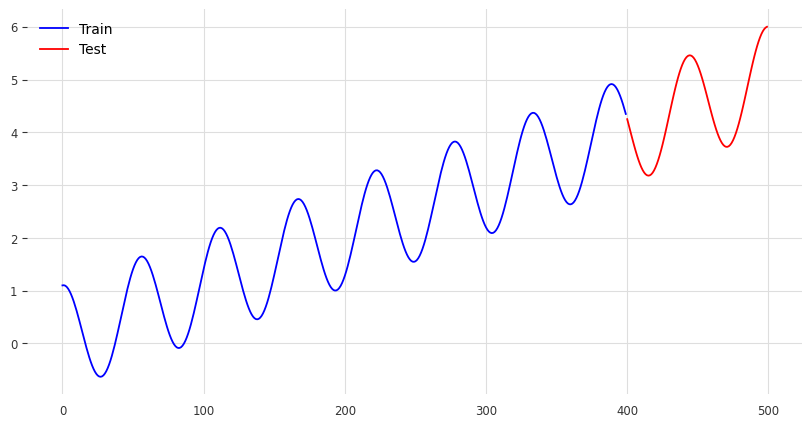

In [18]:
# Sinusoidal Curves - Seasonal stationary data.
def upward_trend_linear(x, frequency=10, amplitude=1, trend_slope=0.1):
    """
    Function that linearly ascends and then descends while maintaining an upward trend.
    
    Parameters:
        x (array-like): Input values.
        ascend_slope (float): Slope of the ascending part of the function.
        descend_slope (float): Slope of the descending part of the function.
        peak_point (float): Point at which the function reaches its peak value.
        
    Returns:
        y (array-like): Output values.
    """
    trend = trend_slope * x
    oscillations = amplitude * np.cos(2 * np.pi * frequency * x)
    y = trend + oscillations
    return y

points = np.linspace(1,50, 500)

aug_series1 = upward_trend_linear(points)


## Train and Test Splitting of Time Series Data
X = aug_series1
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
print(X_train.shape)
print(X_test.shape)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
# plt.plot(X_test, c='red')
plt.legend()
plt.show()


In [19]:
X_train = rearrange(X_train, 'r -> r 1')
X_test = rearrange(X_test, 'r -> r 1')

sc = MinMaxScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [20]:
X_train_std = torch.Tensor(X_train_std)
X_test_std = torch.Tensor(X_test_std)

X_train_std = rearrange(X_train_std, 'b 1 -> b 1 1')
X_test_std = rearrange(X_test_std, 'b 1 -> b 1 1')

print(X_train_std.shape, X_test_std.shape)
type(X_train_std)

torch.Size([400, 1, 1]) torch.Size([100, 1, 1])


torch.Tensor

In [30]:
decomp = series_decomp(25)

In [31]:
seasonal, trend = decomp(X_train_std)

In [32]:
seasonal = rearrange(seasonal, 'r c 1 -> r c')
trend = rearrange(trend, 'r c 1 -> r c')
seasonal.shape

torch.Size([400, 1])

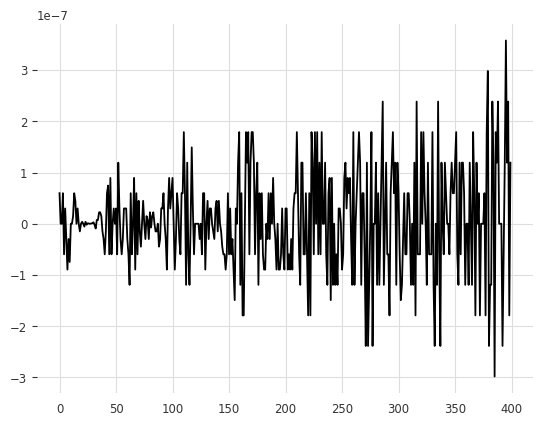

In [33]:
plt.figure()
plt.plot(seasonal)
plt.show()

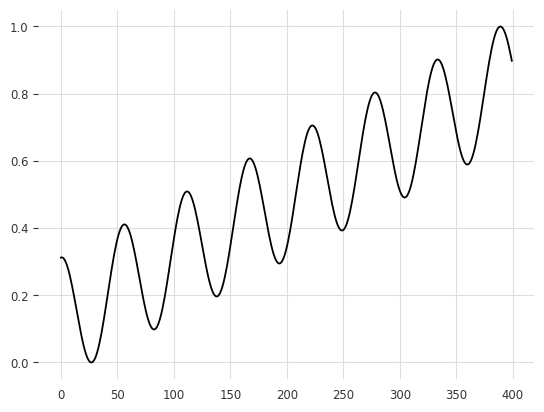

In [34]:
plt.figure()
plt.plot(trend)
plt.show()

In [55]:
abc = torch.randn(150,1,1)
abc.shape

torch.Size([150, 1, 1])

In [56]:
x = abc.squeeze(-1)

In [57]:
x.shape

torch.Size([150, 1])